# Forecasting Energy Demand - Milestone 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

# Preparing the Data

In [2]:
# Loading and preparing the Data Sets 
weather = pd.read_csv('data\hr_temp_20170201-20200131_subset.csv')
energy = pd.read_csv('data\hrl_load_metered - 20170201-20200131.csv')
d = {'MW': energy['mw'], 'Temp': weather['HourlyDryBulbTemperature'], 'Date': weather['DATE']}
df = pd.DataFrame(d)
df['Date'] = pd.to_datetime(df['Date'])
df['hour'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).hour
df['day'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).day
df['weekday'] = df['Date'].dt.dayofweek
df['month'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).month
df['year'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).year
df = df.set_index('Date')
df['Temp'] = df['Temp'].interpolate(method='linear')
#Training and Validation Split #
train = pd.DataFrame(df['2017-01-01':'2019-12-31'])
test = pd.DataFrame(df['2020-01-01':'2020-01-31'])

In [3]:
train.head()

,MW,Temp,hour,day,weekday,month,year
Date,,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,1,2,2,2017
2017-02-01 01:53:00,1379.505,37.0,1,1,2,2,2017
2017-02-01 02:53:00,1366.106,36.0,2,1,2,2,2017
2017-02-01 03:53:00,1364.453,36.0,3,1,2,2,2017
2017-02-01 04:53:00,1391.265,36.0,4,1,2,2,2017


In [4]:
test.head()

,MW,Temp,hour,day,weekday,month,year
Date,,,,,,,
2020-01-01 00:53:00,1363.428,31.0,0,1,2,1,2020
2020-01-01 01:53:00,1335.975,29.0,1,1,2,1,2020
2020-01-01 02:53:00,1296.817,30.0,2,1,2,1,2020
2020-01-01 03:53:00,1288.403,30.0,3,1,2,1,2020
2020-01-01 04:53:00,1292.263,31.0,4,1,2,1,2020


# Building Naive Energy Model

standardize the variable Temp by using the mean and std functions.

In [5]:
train['Temp_Norm'] = (train['Temp']-train['Temp'].mean())/train['Temp'].std()

In [6]:
train['Temp_Norm2'] = train['Temp_Norm']**2

In [7]:
train.head()

,MW,Temp,hour,day,weekday,month,year,Temp_Norm,Temp_Norm2
Date,,,,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,1,2,2,2017,-0.871499,0.759511
2017-02-01 01:53:00,1379.505,37.0,1,1,2,2,2017,-0.871499,0.759511
2017-02-01 02:53:00,1366.106,36.0,2,1,2,2,2017,-0.924494,0.854690
2017-02-01 03:53:00,1364.453,36.0,3,1,2,2,2017,-0.924494,0.854690
2017-02-01 04:53:00,1391.265,36.0,4,1,2,2,2017,-0.924494,0.854690


Build a model

In [8]:
results = sm.OLS.from_formula('MW ~ Temp_Norm + Temp_Norm2 + C(weekday) + C(hour) + C(month)', data=train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     MW   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     3180.
Date:                Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                        20:12:54   Log-Likelihood:            -1.5735e+05
No. Observations:               25536   AIC:                         3.148e+05
Df Residuals:                   25493   BIC:                         3.151e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1272.0274      5.426    2

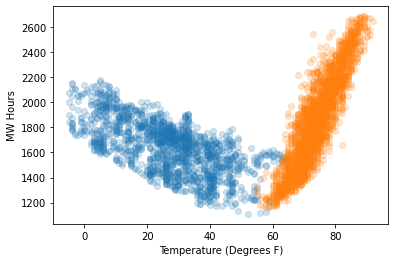

In [9]:
plt.subplot()
plt.scatter(train['Temp'].where(train['month'] == 1), train['MW'].where(train['month'] == 1), alpha = 0.2)
plt.xlabel('Temperature (Degrees F)')
plt.ylabel('MW Hours')

plt.subplot()
plt.scatter(train['Temp'].where(train['month'] == 7), train['MW'].where(train['month'] == 7), alpha = 0.2)
plt.xlabel('Temperature (Degrees F)')
plt.ylabel('MW Hours')

plt.show()

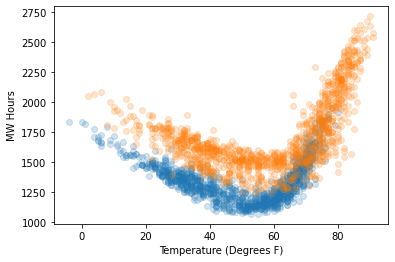

In [10]:
plt.subplot()
plt.scatter(train['Temp'].where(train['hour'] == 0), train['MW'].where(train['hour'] == 0), alpha = 0.2)
plt.xlabel('Temperature (Degrees F)')
plt.ylabel('MW Hours')

plt.subplot()
plt.scatter(train['Temp'].where(train['hour'] == 12), train['MW'].where(train['hour'] == 12), alpha = 0.2)
plt.xlabel('Temperature (Degrees F)')
plt.ylabel('MW Hours')

plt.show()

Let's incorporate these interactions with temperature (and its quadratic term) with hour and month.

In [11]:
results = sm.OLS.from_formula('MW ~ Temp_Norm*C(hour) + Temp_Norm2*C(hour) + Temp_Norm*C(month) + Temp_Norm2*C(month) + C(weekday)*C(hour)', 
                              data=train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     MW   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     1248.
Date:                Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                        20:57:56   Log-Likelihood:            -1.4774e+05
No. Observations:               25536   AIC:                         2.960e+05
Df Residuals:                   25287   BIC:                         2.980e+05
Df Model:                         248                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Calculate the MAPE

In [12]:
train['fitted'] = results.fittedvalues

train['APE'] = abs((train['MW']-train['fitted'])/train['MW'])*100
print("Training Naive Model MAPE is: ", train['APE'].mean())

Training Naive Model MAPE is:  3.511954103205493


Forecast our model by scoring the test data set with the linear regression 

In [13]:
test['Temp_Norm'] = (test['Temp']-test['Temp'].mean())/test['Temp'].std()
test['Temp_Norm2'] = test['Temp_Norm']**2

test['pred'] = results.predict(test)

test.head()

,MW,Temp,hour,day,weekday,month,year,Temp_Norm,Temp_Norm2,pred
Date,,,,,,,,,,
2020-01-01 00:53:00,1363.428,31.0,0,1,2,1,2020,-0.435454,0.189621,1301.224887
2020-01-01 01:53:00,1335.975,29.0,1,1,2,1,2020,-0.627840,0.394184,1296.150033
2020-01-01 02:53:00,1296.817,30.0,2,1,2,1,2020,-0.531647,0.282649,1280.104337
2020-01-01 03:53:00,1288.403,30.0,3,1,2,1,2020,-0.531647,0.282649,1292.227132
2020-01-01 04:53:00,1292.263,31.0,4,1,2,1,2020,-0.435454,0.189621,1334.757899


Plot our predictions for the test data set against the actual values.

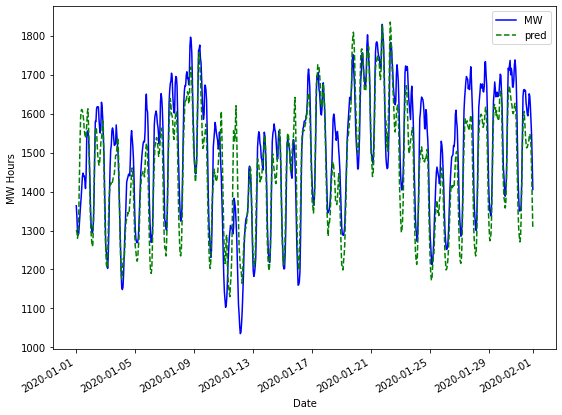

In [14]:
test['MW'].plot(color = 'blue', figsize=(9,7))

plt.ylabel('MW Hours')
plt.xlabel('Date')

test['pred'].plot(color = 'green', linestyle = 'dashed', figsize=(9,7))

plt.legend(loc="best");

plt.show()

Let's see what the MAPE is on these.

In [15]:
test['APE'] = abs((test['MW']-test['pred'])/test['MW'])*100
print("Naive Model MAPE is: ", test['APE'].mean())

Naive Model MAPE is:  4.394719010746601
